In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import sys

In [2]:
import numpy as np
from shutil import copyfile
import matplotlib.pyplot as plt
import sys, os
import dill
sys.path.append('../')
import mg_si
import csv
import datetime
from mg_si import plot as mplt

import signal

class timeout:
    def __init__(self, seconds=1, error_message=None):
        self.seconds = seconds
        if error_message is None:
        	self.error_message = 'solution timed out after {}s'.format(seconds)
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

In [3]:
r_i_real = 1220e3

layer_thickness = 100 # m
overturn = 600 # Myr
times = np.linspace(0,4568e6*365.25*24*3600,40000)

## background mantle state
MgNumFp = 0.8
MgNumPv = 0.93
X_MgFeO_b = 0.311
X_SiO2_b = 0.015
## Mantle viscosity
pl = mg_si.planet.Custom()
nu_present = 10**21/pl.params.mantle.rho #[m^2/s]

T_min_all = 4900
# T_max_all = 6000
T_max_all = 5600
dT = 100

dMg = .01
minMg = 1e-5
maxMg = .1

dO = .01
minO = 1e-5
# maxO = .4
maxO = .25

dSi = .01
minSi = 1e-5
# maxSi = .4
maxSi = .25

T_cmbs = np.linspace(T_min_all,T_max_all,round((T_max_all-T_min_all)/dT)+1)
X_Mgs = np.linspace(minMg,maxMg, round((maxMg-minMg)/dMg)+1)
X_Sis = np.linspace(minSi, maxSi, round((maxSi-minSi)/dSi)+1)
X_Os = np.linspace(minO, maxO, round((maxO-minO)/dO)+1)

vectors = [T_cmbs,X_Mgs,X_Sis,X_Os]

basefolder = '/media/nknezek/compute_storage/explore_space_test/'
alldatafile = 'all_parameters.m'

Ntotal = len(T_cmbs)*len(X_Mgs)*len(X_Sis)*len(X_Os)
i = 1
def compute_one_run(x,iT): 
    T_cmb0 = T_cmbs[x[0]] 
    X_Mg_0 = X_Mgs[x[1]]
    X_Si_0 = X_Sis[x[2]]
    X_O_0 = X_Os[x[3]]
    times = np.linspace(0,4568e6*365.25*24*3600,40000)

    time = str(datetime.datetime.now())
    print('{} - {:.0f}K - {:.3f}Mg {:.3f}Si {:.3f}O'.format(time, T_cmb0, X_Mg_0, X_Si_0, X_O_0))
    pl = mg_si.planet.Custom()
    pl.reactions._set_layer_thickness(layer_thickness)
    pl.reactions._set_overturn_time(overturn)
    deltaT0 = pl.mantle_layer.get_dT0(T_cmb0)
    T_um0 = T_cmb0-deltaT0
    try:
        filepath = basefolder+ "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(T_cmb0, X_Mg_0, X_Si_0, X_O_0)
        if not os.path.exists(basefolder):
            os.mkdir(basefolder)
        if os.path.exists(filepath+'r_i.m'):
            print('r_i already computed')
            r_i = dill.load(open(filepath+'r_i.m','rb'))
            return r_i
        if os.path.exists(filepath+'data.m'):
            print('already computed')
            try:
                pl,times,solution = dill.load(open(filepath+'data.m','rb'))
                r_i = pl.core_layer.r_i(solution[-1,0], one_off=True)
                dill.dump(r_i, open(filepath+'r_i.m','wb'))
                del pl
                return r_i
            except:
                print('could not load previously computed solution, re-computing now')
        if not os.path.exists(filepath):
            os.mkdir(filepath)
    except:
        print('!!!!! Problem setting up folders',sys.exc_info()[1])
        del pl
        return np.nan
    try:
        pl.params.reactions.ParamCitationFeO = 'Fischer2015'
        pl.params.reactions.ParamCitationSiO2 = 'Fischer2015'
        pl.params.reactions.ParamCitationMgO = 'Badro2015'

        Moles_0 = pl.reactions.compute_Moles_0(X_Mg_0, X_Si_0, X_O_0, T_cmb0)
        x0 = [T_cmb0, T_um0]
        x0 = x0+Moles_0
        pl.params.reactions.Moles_0 = Moles_0
        Mm_b = pl.reactions.mantle.compute_Mm_b(X_MgFeO=X_MgFeO_b, X_SiO2=X_SiO2_b, MgNumFp=MgNumFp, MgNumPv=MgNumPv)
        pl.params.reactions.Mm_b = Mm_b
    except:
        print('Problem with initial mole 0',sys.exc_info()[1])
        del pl
        return np.nan
    try:
        T_present = 1350 # [K]
        nu_old =  nu_present/1e3
        T_old = T_um0
        A,nu0 = pl.mantle_layer.find_arrenhius_params(nu_present, T_present, nu_old, T_old, set_values=True)
    except:
        print('!!!!! Problem setting viscosity',sys.exc_info()[1])
        del pl
        return np.nan
    # plot and store solution info
    timeoutsecs = 120
    try:
        with timeout(seconds=timeoutsecs):
            solution = pl.integrate(times, x0)	
    except TimeoutError as err:
        print('!!!!!!',err,'with {} timesteps'.format(len(times)))
        return np.nan
    except:
        print("!!!!!! Unexpected error during solution:",sys.exc_info()[1])
        return np.nan
    try:
        r_i = pl.core_layer.r_i(solution[-1,0], one_off=True)
    except:
        print('!!!!! Problem computing r_i',sys.exc_info()[1])
        del pl
        return np.nan
    try:
        dill.dump(r_i, open(filepath+'r_i.m','wb'))
        dill.dump((pl, times, solution), open(filepath+'data.m','wb'))
    except:
        print('!!!!! Problem saving solution',sys.exc_info()[1])
        del pl
        return r_i
    try:
        # if the inner-core size is within 10% of real inner-core, compute entropy and heat terms
        if np.abs(r_i/r_i_real-1)<.1:
            print('r_i {:.0f} km within 10%, computing and storing entropy history'.format(r_i/1e3))
            t_N, all_parameters = pl.core_layer.compute_all_parameters(times, solution)
#             mplt.Q_all(pl, t_N, all_parameters, filepath=filepath)
            mplt.E_all(pl, t_N, all_parameters, filepath=filepath)
            dill.dump((t_N, all_parameters), open(filepath+alldatafile,'wb'))
            plt.close('all')
        else:
            print('r_i {:.0f} km not within 10%, entropies not computed'.format(r_i/1e3))
        del pl
        print('==== successfully finished computing')
        return r_i
    except:
        print('!!!!! Problem computing entropies',sys.exc_info()[1])
        return r_i

In [4]:
def inspace(x):
    for xd,vec in zip(x,vectors):
        if xd >len(vec)-1 or xd<0:
            return False
    return True
        

In [5]:
x0 = [10,1,1,1]
inspace(x0)

False

In [7]:
x0 = [1,1,1,1]
r_i = compute_one_run(x0,0)
r_i/1e3

2018-05-03 10:31:47.301187 - 5000K - 0.010Mg 0.010Si 0.010O
r_i 2389 km not within 10%, entropies not computed
==== successfully finished computing


2389.162364151409

In [8]:
def isvalid(x,dim=0):
    r_i_real = 1220e3
    r_i = compute_one_run(x,dim)
    return np.abs(r_i/r_i_real-1)<.1

In [9]:
isvalid(x0,0)

2018-05-03 10:31:56.062468 - 5000K - 0.010Mg 0.010Si 0.010O
r_i already computed


False

# Collect Valid Results already computed

In [9]:
import pandas as pd

In [10]:
# datadir = '/media/nknezek/compute_storage/computed_solutions_Fischer2015/'
testdir = '/media/nknezek/compute_storage/explore_space_test/'
all_data = csv.writer(open(testdir+'all_data.csv','w'))
ri10p_data = csv.writer(open(testdir+'ri10p_data.csv','w'))

for i in [0,1,2,3]:
    reader = csv.reader(open(datadir+'run_data{}.csv'.format(i),'r'))
    for row in reader:
        all_data.writerow(row)
        if np.abs(float(row[1])/1220e3-1) < 0.10:
            ri10p_data.writerow(row)

In [62]:
testdir = '/media/nknezek/compute_storage/explore_space_test/'
df10 = pd.read_csv(testdir+'ri10p_data.csv', names=['folder', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0'])
df = df10[['r_i','T_cmb0','X_Mg_0','X_Si_0','X_O_0']]
df.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0
count,5.411000e+03,5411.000000,5411.000000,5411.000000,5411.000000
mean,1.226093e+06,5702.328590,0.025568,0.180647,0.168361
std,6.957754e+04,186.677665,0.019820,0.116903,0.092533
min,1.098070e+06,5300.000000,0.000000,0.000000,0.050000
25%,1.168025e+06,5500.000000,0.010000,0.080000,0.080000
50%,1.230423e+06,5700.000000,0.020000,0.170000,0.170000
75%,1.285045e+06,5900.000000,0.030000,0.280000,0.230000
max,1.341927e+06,6000.000000,0.100000,0.400000,0.400000


In [63]:
dfall = pd.read_csv(testdir+'all_data.csv', names=['folder', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0'])
dfall = dfall[['r_i','T_cmb0','X_Mg_0','X_Si_0','X_O_0']]
dfall.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0
count,1.838900e+04,22250.000000,22250.000000,22250.00000,22250.000000
mean,1.405382e+06,5520.417978,0.024141,0.15330,0.155688
std,4.338939e+05,341.859488,0.018324,0.10923,0.083490
min,0.000000e+00,4900.000000,0.000000,0.00000,0.000000
25%,1.110809e+06,5300.000000,0.010000,0.07000,0.080000
50%,1.318609e+06,5600.000000,0.020000,0.12000,0.150000
75%,1.546602e+06,5800.000000,0.040000,0.23000,0.220000
max,2.467623e+06,6000.000000,0.100000,0.40000,0.400000


In [94]:
df.loc[0]*100

r_i       1.198151e+08
T_cmb0    5.500000e+05
X_Mg_0    2.000000e+00
X_Si_0    3.800000e+01
X_O_0     9.000000e+00
Name: 0, dtype: float64

In [10]:
def get_coords(df,i):
    c = [np.nan]*4
    rtol = 1e-3
    atol = 1e-1
    try:
        c[0] = np.where(np.isclose(df.loc[i,'T_cmb0'],T_cmbs,rtol=rtol,atol=atol))[0][0]
        c[1] = np.where(np.isclose(df.loc[i,'X_Mg_0'],X_Mgs,rtol=rtol,atol=atol))[0][0]
        c[2] = np.where(np.isclose(df.loc[i,'X_Si_0'],X_Sis,rtol=rtol,atol=atol))[0][0]
        c[3] = np.where(np.isclose(df.loc[i,'X_O_0'],X_Os,rtol=rtol,atol=atol))[0][0]
        return tuple(c)
    except:
        return None

In [120]:
valid_solns = set()
for i,_ in df.iterrows():
    valid_solns.add(get_coords(df,i))
valid_solns.remove(None)
len(valid_solns)

328

In [121]:
computed_solns = set()
for i,_ in dfall.iterrows():
    computed_solns.add(get_coords(dfall,i))
computed_solns.remove(None)

len(computed_solns)

1111

# Multiprocessing

In [124]:
from multiprocessing import Process, Queue

In [11]:
def explore_pos(x,dim,dx,valid_solns,computed_solns):
    xp = list(x)
    xp[dim] += dx
    xp = tuple(xp)
    if not inspace(xp):
        return
    if xp in computed_solns:
        return
    computed_solns.add(xp)
    if not isvalid(xp):
        return
    valid_solns.add(xp)
    explore_pos(xp,dim,dx,valid_solns,computed_solns)

def explore_neg(x,dim,dx,valid_solns,computed_solns):
    xm = list(x)
    xm[dim] -= dx
    xm = tuple(xm)
    if not inspace(xm):
        return
    if xm in computed_solns:
        return
    computed_solns.add(xm)
    if not isvalid(xm):
        return
    valid_solns.add(xm)
    explore_neg(xm,dim,dx,valid_solns,computed_solns)

def explore_dim(dim,dx,valid_solns,computed_solns):
    valid_solns0 = set(valid_solns)
    for v in valid_solns0:
        explore_pos(v,dim,dx,valid_solns,computed_solns)
    for v in valid_solns0:
        explore_neg(v,dim,dx,valid_solns,computed_solns)

def multi_explore(dim,dx,valid_solns,computed_solns, q):
    explore_dim(dim,dx,valid_solns,computed_solns)
    q.put([valid_solns,computed_solns])

def run_parallel(dims, dxs, valid_solns, computed_solns):
    qs = []
    ps = []
    for dim in dims:
        qs.append(Queue())
        ps.append(Process(target=multi_explore, args=(dim,dxs[dim],valid_solns,computed_solns,qs[dim])))
        ps[dim].start()
    for dim in dims:
        out = qs[dim].get()    # prints "[42, None, 'hello']"
        valid_solns.update(out[0])
        computed_solns.update(out[1])
        ps[dim].join()

def iter_parallel(dims,dxs,valid_solns,computed_solns, Nmax):
    N = 0
    done = False
    while(not done and N<Nmax):
        N +=1
        Ncomp = len(computed_solns)
        run_parallel(dims,dxs,valid_solns,computed_solns)
        if Ncomp == len(computed_solns):
            done=True
        dill.dump((valid_solns,computed_solns),open(testdir+'solution_coords.m','wb'))
    print('done after {} iters'.format(N))
    print(len(valid_solns),len(computed_solns))
    return valid_solns,computed_solns

In [125]:
Ndim = 4
dims = list(range(Ndim))

dxs = tuple([1]*Ndim)
Nmax = 10

vout, cout = iter_parallel(dims, dxs, valid_solns, computed_solns, Nmax)

2018-04-30 11:06:39.799332 - 5500K - 0.000Mg 0.220Si 0.150O
2018-04-30 11:06:39.804291 - 5600K - 0.010Mg 0.120Si 0.140O
2018-04-30 11:06:39.814069 - 5400K - 0.000Mg 0.010Si 0.230O
2018-04-30 11:06:39.818914 - 5500K - 0.000Mg 0.120Si 0.150O
r_i already computed
r_i already computed
2018-04-30 11:06:39.865067 - 5400K - 0.000Mg 0.220Si 0.160O
2018-04-30 11:06:39.880272 - 5500K - 0.010Mg 0.210Si 0.030O
r_i 1951 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:06:47.896784 - 5400K - 0.000Mg 0.180Si 0.160O
r_i 2091 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:06:49.160990 - 5500K - 0.000Mg 0.210Si 0.120O
r_i 1910 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:06:49.605675 - 5500K - 0.000Mg 0.180Si 0.150O
r_i 1983 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:06:57.948690 - 5400K - 0.000Mg 0.000Si 0.240O
r_i 19

/home/nknezek/.local/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


r_i 1914 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:07:02.612574 - 5500K - 0.010Mg 0.040Si 0.020O
r_i 2093 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:07:09.650962 - 5500K - 0.000Mg 0.150Si 0.150O
r_i already computed
2018-04-30 11:07:09.710470 - 5600K - 0.000Mg 0.220Si 0.150O
r_i 1919 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:07:10.079854 - 5500K - 0.000Mg 0.200Si 0.150O
r_i 1935 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:07:11.857546 - 5600K - 0.000Mg 0.010Si 0.090O
r_i 1922 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:07:20.347596 - 5500K - 0.000Mg 0.160Si 0.160O
r_i 1839 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:07:20.624756 - 5600K - 0.000Mg 0.070Si 0.170O
r_i 2017 km not within 10%, ent

2018-04-30 11:09:51.961528 - 5500K - 0.000Mg 0.020Si 0.200O
r_i 1870 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:09:57.730349 - 5500K - 0.000Mg 0.170Si 0.150O
r_i already computed
2018-04-30 11:09:57.739310 - 5600K - 0.000Mg 0.070Si 0.180O
r_i 1969 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:09:58.168508 - 5400K - 0.000Mg 0.170Si 0.160O
r_i 2019 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:10:02.168385 - 5300K - 0.000Mg 0.040Si 0.190O
r_i 1906 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:10:06.922143 - 5500K - 0.000Mg 0.030Si 0.210O
r_i 1991 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:10:08.037973 - 5500K - 0.000Mg 0.210Si 0.140O
r_i 1997 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:10:09.514650 - 56

==== successfully finished computing
2018-04-30 11:13:03.297799 - 5400K - 0.000Mg 0.190Si 0.160O
r_i 2019 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:13:08.967328 - 5400K - 0.010Mg 0.000Si 0.230O
r_i 2023 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:13:09.300211 - 5500K - 0.000Mg 0.240Si 0.120O
r_i already computed
2018-04-30 11:13:09.312974 - 5600K - 0.000Mg 0.090Si 0.160O
r_i already computed
2018-04-30 11:13:09.326083 - 5500K - 0.000Mg 0.150Si 0.150O
r_i already computed
2018-04-30 11:13:09.342634 - 5500K - 0.000Mg 0.010Si 0.210O
r_i already computed
2018-04-30 11:13:09.346135 - 5400K - 0.000Mg 0.150Si 0.160O
r_i 1978 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:13:12.804584 - 5500K - 0.000Mg 0.110Si 0.170O
r_i already computed
2018-04-30 11:13:12.850907 - 5400K - 0.000Mg 0.050Si 0.200O
r_i 1891 km not within 10%, entropies not computed
===

r_i already computed
r_i 1636 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:15:42.841026 - 5600K - 0.010Mg 0.020Si 0.210O
r_i 1546 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:15:47.271090 - 5500K - 0.010Mg 0.150Si 0.010O
r_i 2019 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:15:55.842159 - 5400K - 0.010Mg 0.040Si 0.000O
!!!!!! Unexpected error during solution: dTdt should not be >0., something is wrong.
2018-04-30 11:15:55.878764 - 5500K - 0.010Mg 0.150Si 0.020O
r_i 1989 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:16:06.627898 - 5500K - 0.010Mg 0.240Si 0.020O
r_i 1970 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:16:17.508224 - 5600K - 0.010Mg 0.250Si 0.000O
r_i 1970 km not within 10%, entropies not computed
==== successfully finished computing
2018-0

2018-04-30 11:21:38.851609 - 5400K - 0.010Mg 0.170Si 0.010O
r_i 2093 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:21:47.897337 - 5500K - 0.010Mg 0.180Si 0.030O
r_i 1925 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:22:00.996645 - 5500K - 0.010Mg 0.010Si 0.220O
r_i 1725 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:22:05.914821 - 5500K - 0.010Mg 0.130Si 0.020O
r_i 1994 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:22:16.578442 - 5400K - 0.010Mg 0.020Si 0.010O
r_i 2093 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:22:26.696919 - 5600K - 0.010Mg 0.040Si 0.000O
!!!!!! Unexpected error during solution: dTdt should not be >0., something is wrong.
2018-04-30 11:22:26.726485 - 5400K - 0.010Mg 0.210Si 0.150O
r_i 1861 km not within 10%, entropies not computed
====

==== successfully finished computing
2018-04-30 11:27:09.712926 - 5500K - 0.010Mg 0.240Si 0.030O
r_i 1905 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:27:21.103529 - 5400K - 0.010Mg 0.230Si 0.000O
r_i 1905 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:27:21.238453 - 5600K - 0.010Mg 0.250Si 0.120O
r_i already computed
2018-04-30 11:27:21.251020 - 5500K - 0.010Mg 0.110Si 0.000O
r_i 1905 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:27:21.373561 - 5400K - 0.010Mg 0.040Si 0.190O
r_i 1826 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:27:24.952156 - 5600K - 0.010Mg 0.250Si 0.150O
r_i 1608 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:27:29.217074 - 5600K - 0.010Mg 0.140Si 0.140O
r_i already computed
2018-04-30 11:27:29.235225 - 5600K - 0.010Mg 0.220Si 0.130O
r

r_i already computed
2018-04-30 11:31:33.702085 - 5500K - 0.010Mg 0.210Si 0.130O
r_i 1667 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:31:37.904958 - 5500K - 0.010Mg 0.170Si 0.010O
r_i 2020 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:31:47.846826 - 5600K - 0.010Mg 0.010Si 0.040O
r_i 1929 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:31:58.219580 - 5600K - 0.010Mg 0.120Si 0.160O
r_i 1570 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:32:01.706332 - 5600K - 0.010Mg 0.010Si 0.070O
r_i 1804 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:32:13.678042 - 5500K - 0.010Mg 0.000Si 0.000O
!!!!!! Unexpected error during solution: dTdt should not be >0., something is wrong.
2018-04-30 11:32:13.719909 - 5400K - 0.010Mg 0.150Si 0.010O
r_i 2094 km not within 10%, entrop

==== successfully finished computing
2018-04-30 11:36:35.895779 - 5500K - 0.010Mg 0.060Si 0.020O
r_i 2013 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:36:46.361189 - 5400K - 0.010Mg 0.160Si 0.010O
r_i 2093 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:36:56.560844 - 5600K - 0.010Mg 0.220Si 0.000O
r_i 2093 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:36:56.706546 - 5600K - 0.010Mg 0.180Si 0.120O
r_i already computed
2018-04-30 11:36:56.786742 - 5500K - 0.010Mg 0.190Si 0.030O
r_i 1922 km not within 10%, entropies not computed
==== successfully finished computing
2018-04-30 11:37:08.139363 - 5600K - 0.010Mg 0.110Si 0.140O
r_i already computed
2018-04-30 11:37:08.156335 - 5400K - 0.010Mg 0.010Si 0.000O
!!!!!! Unexpected error during solution: dTdt should not be >0., something is wrong.
2018-04-30 11:37:08.195604 - 5500K - 0.010Mg 0.020Si 0.020O
r_i 

# Collect Solutions

In [12]:
import os
import csv
import numpy as np
import dill
import pandas as pd

In [130]:
def get_ri(filepath):
    if os.path.exists(filepath+'r_i.m'):
#         print('r_i already computed')
        r_i = dill.load(open(filepath+'r_i.m','rb'))
        return r_i
    if os.path.exists(filepath+'data.m'):
#         print('already computed')
        try:
            pl,times,solution = dill.load(open(filepath+'data.m','rb'))
            r_i = pl.core_layer.r_i(solution[-1,0], one_off=True)
            dill.dump(r_i, open(filepath+'r_i.m','wb'))
            del pl
            return r_i
        except:
            print('could not load ri')
            return np.nan

In [135]:
datadir = '/media/nknezek/compute_storage/explore_space_test/'
all_data = csv.writer(open(datadir+'all_data.csv','w'))
ri10p_data = csv.writer(open(datadir+'ri10p_data.csv','w'))


In [136]:
ri_real = 1220e3
for root,dirs,files in os.walk(datadir):
    for d in dirs:
        filepath = root+d+'/'
#         print(filepath)
        ri = get_ri(filepath)
        vals = [x[2:] for x in d.split('_')]
        row = [filepath,ri]+vals
        all_data.writerow(row)
        try:
            if np.abs(ri/ri_real-1)<.1:
                ri10p_data.writerow(row)
        except:
            pass

In [142]:
dfall = pd.read_csv(datadir+'all_data.csv', names=['filepath', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0'])
dfall.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0
count,1.985000e+04,23925.000000,23925.000000,23925.000000,23925.000000
mean,1.449026e+06,5510.654127,0.022608,0.150553,0.152568
std,4.480388e+05,332.349523,0.018562,0.107768,0.083896
min,0.000000e+00,4900.000000,0.000000,0.000000,0.000000
25%,1.128789e+06,5300.000000,0.010000,0.070000,0.080000
50%,1.348452e+06,5500.000000,0.020000,0.120000,0.140000
75%,1.758773e+06,5800.000000,0.030000,0.220000,0.210000
max,3.480000e+06,6000.000000,0.100000,0.400000,0.400000


In [150]:
df10 = pd.read_csv(datadir+'ri10p_data.csv', names=['filepath', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0'])
df10.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0
count,5.440000e+03,5440.000000,5440.000000,5440.000000,5440.000000
mean,1.225923e+06,5701.764706,0.025540,0.180781,0.168423
std,6.963129e+04,187.042601,0.019835,0.116863,0.092377
min,1.098070e+06,5300.000000,0.000000,0.000000,0.050000
25%,1.167594e+06,5500.000000,0.010000,0.080000,0.080000
50%,1.230290e+06,5700.000000,0.020000,0.170000,0.170000
75%,1.284884e+06,5900.000000,0.030000,0.280000,0.230000
max,1.341927e+06,6000.000000,0.100000,0.400000,0.400000


In [13]:
def compute_all_data(df,basedir,solutionfile,alldatafile):
    icfile = 'icnucleation.m'
    recompute=False
    dt0=1
    dt1=100
    for i,row in df.iterrows():
        print(i)
        solution = None
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        # Inner-core nucleation and entropy jump
        if os.path.isfile(basedir+foldername+icfile) and not recompute:
            t_ic, i_ic,(dEp,dt0,dt1) = dill.load(open(basedir+foldername+icfile,'rb'))
        else:
            # compute ic nucleation time if haven't already done so
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_ic, i_ic = find_ic_nucleation(pl,times,solution,Napprox=4568)        
            dEp = ent_jump_ic_nuc(pl,times,solution, i_ic, dt0=dt0, dt1=dt1)
            dill.dump((t_ic,i_ic,(dEp, dt0,dt1)), open(basedir+foldername+icfile,'wb'))
        df.loc[i,'i_ic'] = i_ic
        df.loc[i,'t_ic'] = t_ic
        df.loc[i,'dE_ic'] = dEp
        if solution is None:
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        M_c, M_m = pl.reactions.unwrap_Moles(solution[-1, 2:], return_sum=False, split_coremantle=True)
        wt_m = pl.reactions.mantle.M2wtp(np.array(M_m))*100
        wt_c = pl.reactions.core.M2wtp(np.array(M_c))*100
        # M_Mg, M_Si, M_Fe, M_O, M_MgO, M_SiO2, M_FeO, M_MgSiO3, M_FeSiO3  
        df.loc[i,'wt_Mg_p'] = wt_c[0]
        df.loc[i,'wt_Si_p']= wt_c[1]
        df.loc[i,'wt_Fe_p']= wt_c[2]
        df.loc[i,'wt_O_p']=wt_c[3]
        df.loc[i,'wt_MgO_p']= wt_m[0]
        df.loc[i,'wt_SiO2_p']= wt_m[1]
        df.loc[i,'wt_FeO_p']= wt_m[2]
        df.loc[i,'wt_MgSiO3_p']= wt_m[3]
        df.loc[i,'wt_FeSiO3_p']= wt_m[4]

        M_c0, M_m0 = pl.reactions.unwrap_Moles(solution[0, 2:], return_sum=False, split_coremantle=True)
        wt_c0 = pl.reactions.core.M2wtp(np.array(M_c0))*100

        df.loc[i,'wt_Mg_0'] = wt_c0[0]
        df.loc[i,'wt_Si_0']= wt_c0[1]
        df.loc[i,'wt_Fe_0']= wt_c0[2]
        df.loc[i,'wt_O_0']=wt_c0[3]

        if not os.path.exists(datadir+foldername+alldatafile):
            t_N, allp = pl.core_layer.compute_all_parameters(times, solution)
            dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
        else:
            t_N, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        CE = 1e6
        E_MgO =  np.nanmean(allp.Egm)/CE
        E_FeO =  np.nanmean(allp.Egf)/CE
        E_SiO2 =  np.nanmean(allp.Egs)/CE
        E_s =  np.nanmean(allp.Es)/CE

        df.loc[i,'E_MgO_t'] = E_MgO
        df.loc[i,'E_FeO_t'] = E_FeO
        df.loc[i,'E_SiO2_t'] = E_SiO2
        df.loc[i,'E_ex_t'] = np.nanmean(allp.Eex)/CE
        df.loc[i,'E_s_t'] = E_s
        if E_s > E_MgO+E_FeO+E_SiO2:
            df.loc[i,'maxE'] = 'cooling'
        else:
            if E_MgO > E_FeO and E_MgO > E_SiO2:
                df.loc[i,'maxE'] = 'MgO'
            elif E_FeO > E_SiO2:
                df.loc[i,'maxE'] = 'FeO'
            else:
                df.loc[i,'maxE'] = 'SiO2'
    df['ex_s_rat'] = df['E_ex_t']/df['E_s_t']
    df['ex_s_diff'] = (df['E_ex_t'] - df['E_s_t']) / (df['E_ex_t'] + df['E_s_t'])        
        
    df['wt_MgSi_p'] = df['wt_Mg_p'] +df['wt_Si_p']
    df['wt_MgSi_0'] = df['wt_Mg_0'] +df['wt_Si_0'] 
    return df

def compute_ic_nucleation(df, basedir, solutionfile, alldatafile, icfile = 'icnucleation.m', recompute=False, dt0=1, dt1=100):    
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        if os.path.isfile(basedir+foldername+icfile) and not recompute:
            t_ic, i_ic,(dEp,dt0,dt1) = dill.load(open(basedir+foldername+icfile,'rb'))
        else:
            # compute ic nucleation time if haven't already done so
            pl, t, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_ic, i_ic = find_ic_nucleation(pl,t,solution,Napprox=4568)        
            dEp = ent_jump_ic_nuc(pl,t,solution, i_ic, dt0=dt0, dt1=dt1)
            dill.dump((t_ic,i_ic,(dEp, dt0,dt1)), open(basedir+foldername+icfile,'wb'))
        df.loc[i,'i_ic'] = i_ic
        df.loc[i,'t_ic'] = t_ic
        df.loc[i,'dE_ic'] = dEp
    return df

def find_ic_nucleation(pl,t,solution, Napprox=10000):
    di = max(1,int(len(t)/Napprox))
    i = 0
    Tc = solution[:,0]
    found = False
    while(found==False):        
        if i*di > len(Tc):
            return np.nan, np.nan
        r_t = pl.core_layer.r_i(Tc[i*di], one_off=True)
        i+=1     
        if r_t > 0.:
            found = True
    return t[i*di], i*di

def compute_Ephi(pl,t,solution,ind):
    Tc = solution[ind,0]
    dTdt = (solution[ind+1,0]-solution[ind,0])/(t[ind+1]-t[ind])
    h = pl.core_layer.heat_production_per_kg(t[ind])    
    E_phi = pl.core_layer.E_phi(Tc, dTdt, h, solution[ind,2:], time=t[ind],recompute=True, store_computed=False)
    return E_phi

def ent_jump_ic_nuc(pl,t,solution,ind_icn, return_percent=True, return_raw=False, dt0=1, dt1=100):
    dt = t[ind_icn+1] - t[ind_icn]
    i0 = ind_icn - int(dt0*Myrs/dt)
    i1 = ind_icn + int(dt1*Myrs/dt)
    Ephi0 = compute_Ephi(pl,t,solution, i0)
    Ephi1 = compute_Ephi(pl,t,solution, i1)
    if return_percent:
        return (Ephi1-Ephi0)/Ephi0
    elif return_raw:
        return Ephi0, Ephi1
    else:
        return Ephi1-Ephi0

def compute_wtp(df,basedir,solutionfile,alldatafile):
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
                continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        M_c, M_m = pl.reactions.unwrap_Moles(solution[-1, 2:], return_sum=False, split_coremantle=True)
        wt_m = pl.reactions.mantle.M2wtp(np.array(M_m))*100
        wt_c = pl.reactions.core.M2wtp(np.array(M_c))*100
        # M_Mg, M_Si, M_Fe, M_O, M_MgO, M_SiO2, M_FeO, M_MgSiO3, M_FeSiO3  
        df.loc[i,'wt_Mg_p'] = wt_c[0]
        df.loc[i,'wt_Si_p']= wt_c[1]
        df.loc[i,'wt_Fe_p']= wt_c[2]
        df.loc[i,'wt_O_p']=wt_c[3]
        df.loc[i,'wt_MgO_p']= wt_m[0]
        df.loc[i,'wt_SiO2_p']= wt_m[1]
        df.loc[i,'wt_FeO_p']= wt_m[2]
        df.loc[i,'wt_MgSiO3_p']= wt_m[3]
        df.loc[i,'wt_FeSiO3_p']= wt_m[4]

        M_c0, M_m0 = pl.reactions.unwrap_Moles(solution[0, 2:], return_sum=False, split_coremantle=True)
        wt_c0 = pl.reactions.core.M2wtp(np.array(M_c0))*100

        df.loc[i,'wt_Mg_0'] = wt_c0[0]
        df.loc[i,'wt_Si_0']= wt_c0[1]
        df.loc[i,'wt_Fe_0']= wt_c0[2]
        df.loc[i,'wt_O_0']=wt_c0[3]
    df['wt_MgSi_p'] = df['wt_Mg_p'] +df['wt_Si_p']
    df['wt_MgSi_0'] = df['wt_Mg_0'] +df['wt_Si_0']
    return df

def compute_Entropy_from_sources(df,basedir,solutionfile,alldatafile ):
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(datadir+foldername+alldatafile):
            if not os.path.exists(basedir+foldername+solutionfile):
                continue
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_N, allp = pl.core_layer.compute_all_parameters(times, solution)
            dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
        else:
            t_N, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        CE = 1e6
        E_MgO =  np.nanmean(allp.Egm)/CE
        E_FeO =  np.nanmean(allp.Egf)/CE
        E_SiO2 =  np.nanmean(allp.Egs)/CE
        E_s =  np.nanmean(allp.Es)/CE

        df.loc[i,'E_MgO_t'] = E_MgO
        df.loc[i,'E_FeO_t'] = E_FeO
        df.loc[i,'E_SiO2_t'] = E_SiO2
        df.loc[i,'E_ex_t'] = np.nanmean(allp.Eex)/CE
        df.loc[i,'E_s_t'] = E_s
        if E_s > E_MgO+E_FeO+E_SiO2:
            df.loc[i,'maxE'] = 'cooling'
        else:
            if E_MgO > E_FeO and E_MgO > E_SiO2:
                df.loc[i,'maxE'] = 'MgO'
            elif E_FeO > E_SiO2:
                df.loc[i,'maxE'] = 'FeO'
            else:
                df.loc[i,'maxE'] = 'SiO2'
    df['ex_s_rat'] = df['E_ex_t']/df['E_s_t']
    df['ex_s_diff'] = (df['E_ex_t'] - df['E_s_t']) / (df['E_ex_t'] + df['E_s_t'])
    return df

In [166]:
basedir = '/media/nknezek/compute_storage/explore_space_test/'
solutionfile = 'data.m'
alldatafile = 'all_parameters.m'
compute_all_data(df10,basedir,solutionfile,alldatafile)
df10.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,wt_Mg_p,wt_Si_p,wt_Fe_p,wt_O_p,wt_MgO_p,...,i_ic,t_ic,dE_ic,E_MgO_t,E_FeO_t,E_SiO2_t,E_ex_t,E_s_t,ex_s_rat,ex_s_diff
count,5.440000e+03,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,...,5440.000000,5.440000e+03,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000
mean,1.225923e+06,5701.764706,0.025540,0.180781,0.168423,0.390310,11.758780,83.025906,4.825005,25.394206,...,35308.996324,1.273810e+17,1.176379,242.388955,31.684752,467.853045,741.926753,501.076031,1.527803,0.179560
std,6.963129e+04,187.042601,0.019835,0.116863,0.092377,0.730775,8.691501,8.792565,3.850952,27.981172,...,1047.717290,2.458777e+15,0.852474,201.294317,51.406932,177.951890,165.090354,52.730159,0.489263,0.155271
min,1.098070e+06,5300.000000,0.000000,0.000000,0.050000,0.000579,0.000539,59.574094,0.149697,0.657379,...,17244.000000,1.218430e+17,-11.708664,0.000000,0.000000,0.000000,204.087221,383.027592,0.346684,-0.485129
25%,1.167594e+06,5500.000000,0.010000,0.080000,0.080000,0.011136,4.115806,76.860988,1.228228,2.990070,...,34752.000000,1.252667e+17,0.678283,74.844955,0.084569,395.816099,627.188849,446.956694,1.162623,0.075197
50%,1.230290e+06,5700.000000,0.020000,0.170000,0.170000,0.049218,10.076523,83.644196,4.285750,11.749575,...,35352.000000,1.274075e+17,1.074632,186.683399,9.131533,499.843622,718.316772,504.514890,1.401096,0.167047
75%,1.284884e+06,5900.000000,0.030000,0.280000,0.230000,0.390931,18.535967,90.159938,7.640868,41.980821,...,35928.000000,1.294834e+17,1.428112,384.415925,39.917443,565.263384,879.745076,553.282188,1.937621,0.319177
max,1.341927e+06,6000.000000,0.100000,0.400000,0.400000,4.427290,32.942252,98.573001,16.262234,98.936871,...,36760.000000,1.324819e+17,17.916303,926.656905,371.224576,1174.048805,1482.623340,588.782639,3.870800,0.589390


In [167]:
dill.dump(df10,open('dataframe_r10_allcomputed_Fischer.m','wb'))

# Plotting


In [14]:
import matplotlib.path as mplPath
import matplotlib.patches as patches

In [22]:
cnames = ['FeO','MgO','SiO2','cooling']

def get_color(cname):
    cnames = ['FeO','MgO','SiO2','cooling']
    coolcolor = (1,0,0,1)
    scolor = (0.2, 0.6274509803921569, 0.17254901960784313,1)
    fcolor  = (0.7294117647058823, 0.3333333333333333, 0.8274509803921568,1)
    mcolor = (0.0, 0.7490196078431373, 1.0,1)
    colors = [fcolor,mcolor,scolor, coolcolor]
    return colors[cnames.index(cname)]

def maxE_color(df, cvar='maxE'):
    cvals = df[cvar].fillna('FeO')
    colors = np.array([get_color(v) for v in cvals])
    colors[df[cvar].isnull()] = (1,1,1,0)    
    return colors

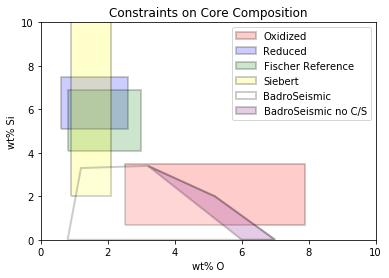

In [27]:
FischerOxidizedPath = mplPath.Path(np.array([(2.5,.7),(2.5,3.5),(7.9,3.5),(7.9,.7),(2.5,.7)]))
FischerReducedPath = mplPath.Path(np.array([(.6,5.1),(.6,7.5),(2.6,7.5),(2.6,5.1),(.6,5.1)]))
FischerReferencePath = mplPath.Path(np.array([(.8,4.1),(3,4.1),(3,6.9),(.8,6.9),(.8,4.1)]))

SiebertOSiPath = mplPath.Path(np.array([(.9,2),(2.1,2),(2.1,13),(.9,13),(.9,2)]))

BadroSeismicOSiPath = mplPath.Path(np.array([[0.8, 0. ],
       [1.2, 3.3],
       [3.2, 3.4],
       [5.2, 2. ],
       [7. , 0. ],[0.8, 0. ]]), None)
BadroSeismicOSinoCSPath = mplPath.Path(np.array([[6, 0. ],
       [3.2, 3.4],
       [5.2, 2. ],
       [7. , 0. ],[6, 0. ]]), None)
plt.figure()
ax = plt.subplot(111)
patch = patches.PathPatch(FischerOxidizedPath, lw=2., facecolor='red',alpha=.2,label='Oxidized')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Fischer Reference')
ax.add_patch(patch)
patch = patches.PathPatch(SiebertOSiPath, lw=2., facecolor='yellow', alpha=.2,label='Siebert')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSiPath, lw=2., facecolor='white', alpha=.2,label='BadroSeismic')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, lw=2., facecolor='purple', alpha=.2,label='BadroSeismic no C/S')
ax.add_patch(patch)
plt.xlim(0,10)
plt.ylim(0,10)
plt.legend()
plt.title('Constraints on Core Composition')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.savefig('core constraints.pdf')

In [39]:
datadir = '/media/nknezek/compute_storage/explore_space_test/'
df10 = dill.load(open('dataframe_r10_allcomputed_Fischer.m','rb'))
solutionfile = 'data.m'
alldatafile = 'all_parameters.m'

df10 = df10[df10['wt_Mg_0']<2]
df10 = df10[df10['wt_O_0']<20]
df10 = df10[df10['wt_Si_0']<20]
# df10 = df10[df10['T_cmb0']<=5700]
# df10 = df10[df10['T_cmb0']>=5400]
df10['E_ex_t'].describe()


count    3304.000000
mean      696.622096
std       164.555104
min       204.087221
25%       597.326802
50%       671.365907
75%       787.286857
max      1482.623340
Name: E_ex_t, dtype: float64

(0, 4)

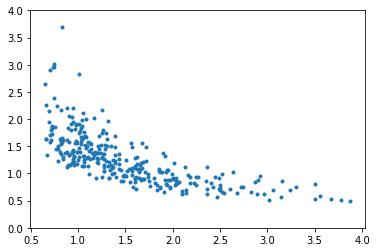

In [542]:
plt.plot(df10['E_ex_t']/df10['E_s_t'],df10['dE_ic'],'.')
plt.ylim(0,4)

In [544]:
# cvals = (df10['T_cmb0']-5000)/1000
cvals = (df10['X_Mg_0'])/.04
colors= plt.cm.rainbow(cvals)

NameError: name 'co' is not defined

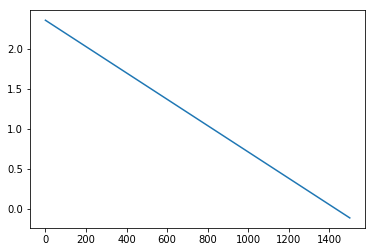

In [591]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<20]
df = df[df['wt_Si_0']<20]
pf = np.polyfit(df['E_ex_t'],df['dE_ic'],1)
x = np.linspace(0.1,1500)
yfit = np.polyval(pf,x)
plt.plot(x,yfit)
for x,y,c in zip(df['E_ex_t'],df['dE_ic'],co):
    plt.plot(np.log(x),y,'.',color=c)
plt.xlabel('entropy from light-element precipitation (MW/K)')
plt.ylabel('% change in entropy')
plt.title('% change in entropy with inner-core nucleation')
plt.grid()
plt.ylim(0,4)
plt.xlim(0,1500)

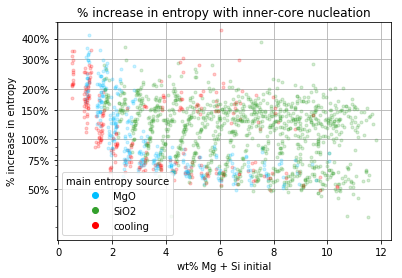

In [679]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['wt_MgSi_0'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('wt% Mg + Si initial')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('wtpMgSi_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

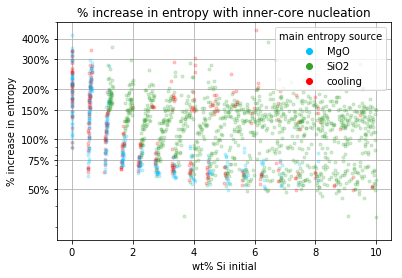

In [681]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['wt_Si_0'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('wt% Si initial')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('wtpSi_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

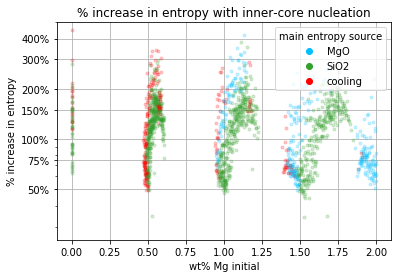

In [682]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['wt_Mg_0'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('wt% Mg initial')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('wtpMg_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

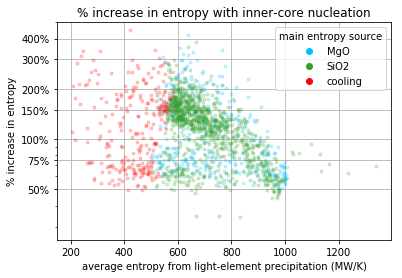

In [670]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_ex_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('average entropy from light-element precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('entropy_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

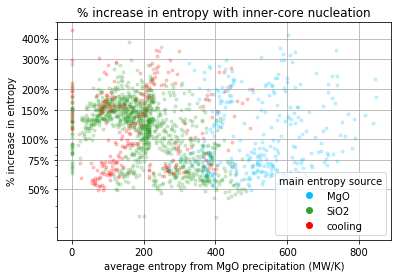

In [674]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_MgO_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('average entropy from MgO precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('entropyMgO_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

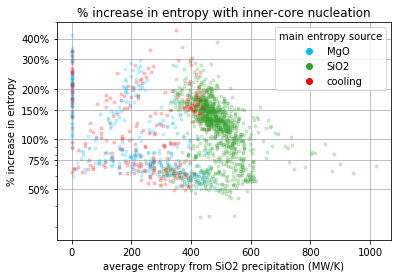

In [677]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_SiO2_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('average entropy from SiO2 precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('entropySiO2_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

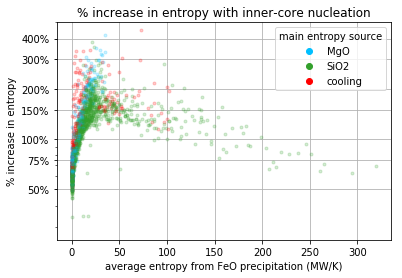

In [678]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_FeO_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('average entropy from FeO precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('entropyFeO_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

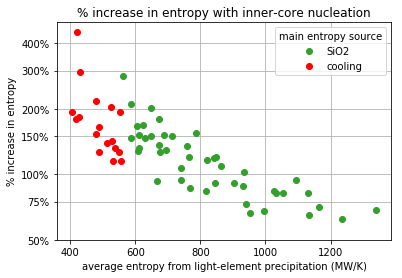

In [659]:
# plt.close('all')
df = df10[df10['wt_Mg_0']<.2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)

for x,y,c in zip(df['E_ex_t'],df['dE_ic'],colors):
    if y>0:
        plt.plot(x,np.log(y*100),'o',color=c)

plt.xlabel('average entropy from light-element precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
plt.legend(handles=lpatchs[2:], title='main entropy source')
plt.grid()
yticks = [50,75,100,150,200, 300,400]
plt.yticks(np.log(yticks),['{:.0f}%'.format(x) for x in yticks])
plt.ylim(np.log(50),np.log(500))
plt.savefig('entropy_vs_ic_Fischer_noMg.pdf')


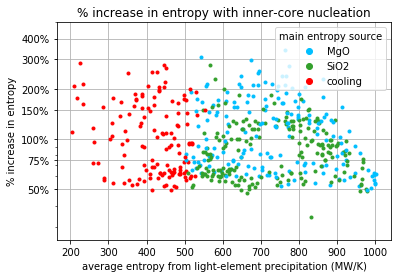

In [52]:
df = df10[df10['wt_Mg_0']<=2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

# df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]

# df = df[(df['in_FischerReferenceInitial']==True) | (df['in_BadroSeismicPresent']==True)]
# df = df[(df['in_FischerReferenceInitial']==True) | (df['in_BadroSeismicPresent']==True)| (df['in_SiebertOSiPath']==True)]
df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]

# df = df[df['in_BadroSeismicPresent']==True]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_ex_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=1)
plt.xlabel('average entropy from light-element precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source',)
plt.savefig('entropy_vs_ic_Fischer_SeismicConstraint.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

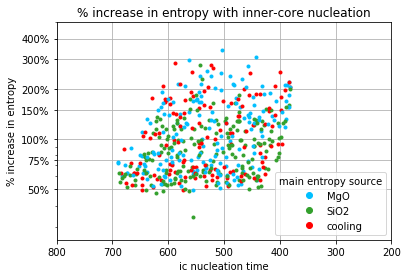

In [61]:
df = df10[df10['wt_Mg_0']<=2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

# df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]

# df = df[(df['in_FischerReferenceInitial']==True) | (df['in_BadroSeismicPresent']==True)]
# df = df[(df['in_FischerReferenceInitial']==True) | (df['in_BadroSeismicPresent']==True)| (df['in_SiebertOSiPath']==True)]
df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]

# df = df[df['in_BadroSeismicPresent']==True]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(4560-df['t_ic']/Myrs,df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=1)
plt.xlabel('ic nucleation time')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)
plt.xlim(800,200)
plt.legend(handles=lpatchs[1:], title='main entropy source',)
plt.savefig('entropy_jump_ic_vs_time_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

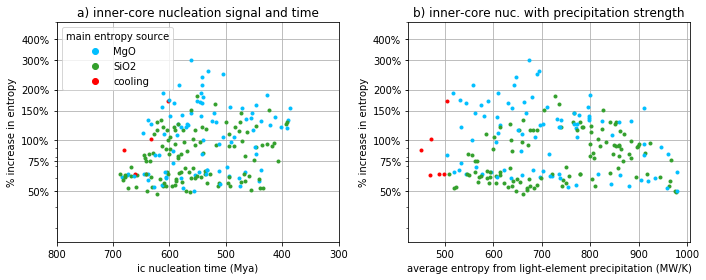

In [78]:
df = df10
df = df[df['wt_O_p']<=10]
# df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]


plt.figure(figsize=(10,4))
plt.subplot(121)


lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(4560-df['t_ic']/Myrs,df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=1)
plt.xlabel('ic nucleation time (Mya)')
plt.ylabel('% increase in entropy')
plt.title('a) inner-core nucleation signal and time')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)
plt.xlim(800,300)
plt.legend(handles=lpatchs[1:], title='main entropy source',)


plt.subplot(122)

# df = df[df['in_BadroSeismicPresent']==True]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_ex_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=1)
plt.xlabel('average entropy from light-element precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('b) inner-core nuc. with precipitation strength')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)


plt.tight_layout()
plt.savefig('ic_info_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

(0, 4)

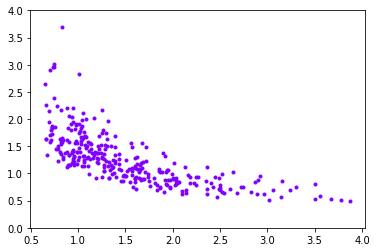

In [546]:
for x,y,c in zip(df10['E_ex_t']/df10['E_s_t'],df10['dE_ic'],colors):
    plt.plot(x,y,'.',color=c)

plt.ylim(0,4)

(0, 5)

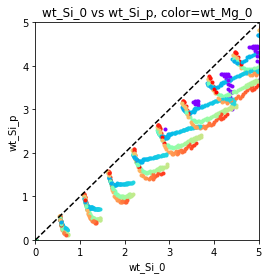

In [301]:
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_0'

cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


(0, 5)

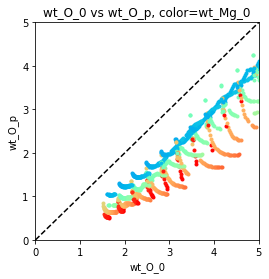

In [302]:
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


# Oxidized Initial and Final Constraints (Fischer and Badro)

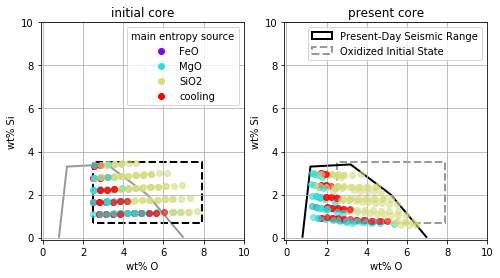

In [376]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=7]
df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=3.3]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[df['in_BadroSeismicPresent']==True]
df = df[df['in_FischerOxidizedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
# ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
# ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
plt.savefig('Initial_Final_core_composition.pdf')

# Reference Initial and Final Constraints (Fischer and Badro)

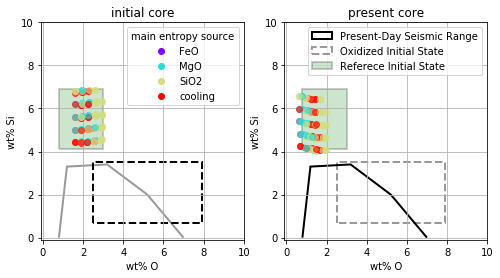

In [667]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=10]
# df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=10]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

# df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
plt.savefig('Initial_Final_core_composition_FischerReference.pdf')

# Reduced Initial and Final Constraints (Fischer and Badro)

In [534]:
BadroSeismicOSiPath

Path(array([[0.8, 0. ],
       [1.2, 3.3],
       [3.2, 3.4],
       [5.2, 2. ],
       [7. , 0. ]]), None)

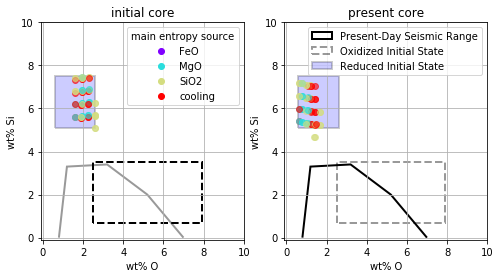

In [668]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=10]
# df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=10]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

# df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
df = df[df['in_FischerReducedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
# ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
# ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
plt.savefig('Initial_Final_core_composition_FischerReduced.pdf')

# Final Constraints (Badro)

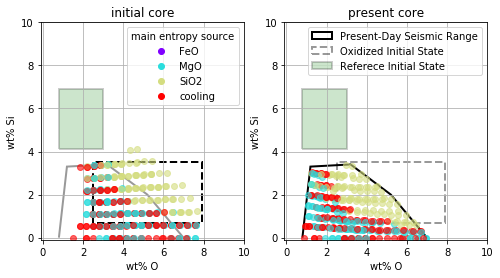

In [669]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=10]
# df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=10]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Reference Initial State')
ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()



plt.savefig('Initial_Final_core_composition_Fischer_BadroSeismicFinalPlotted.pdf')

# Final Constraints (Badro)

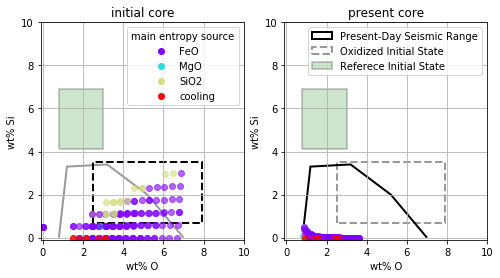

In [56]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=10]
# df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=10]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
plt.savefig('Initial_Final_core_composition_BadroSeismicFinalPlotted.pdf')

In [486]:
mpl.colors.cnames

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3

(0, 5)

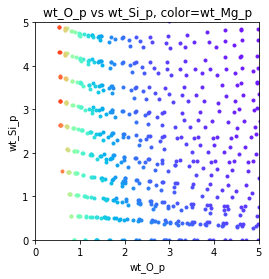

In [251]:
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_p'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


In [508]:
mpl.colors.hex2color('#00BFFF')

(0.0, 0.7490196078431373, 1.0)

# Oxidized Initial and Final Constraints (Fischer and Badro)

In [525]:
df = df[df['maxE']=='SiO2']


In [529]:
df['deltawtO'] = df['wt_O_0']-df['wt_O_p']

In [530]:
df['deltawtSi'] = df['wt_Si_0']-df['wt_Si_p']

In [531]:
df['deltawtMg'] = df['wt_Mg_0']-df['wt_Mg_p']

In [533]:
df[['deltawtO','deltawtSi','deltawtMg']].describe()

,deltawtO,deltawtSi,deltawtMg
count,90.000000,90.000000,90.000000
mean,1.102760,0.549777,0.641411
std,0.158742,0.123306,0.250151
min,0.840385,0.327865,0.312360
25%,0.984677,0.462976,0.416261
50%,1.080199,0.523533,0.609235
75%,1.204960,0.594721,0.877325
max,1.613121,0.871094,1.293923


# Final Form 4-panel

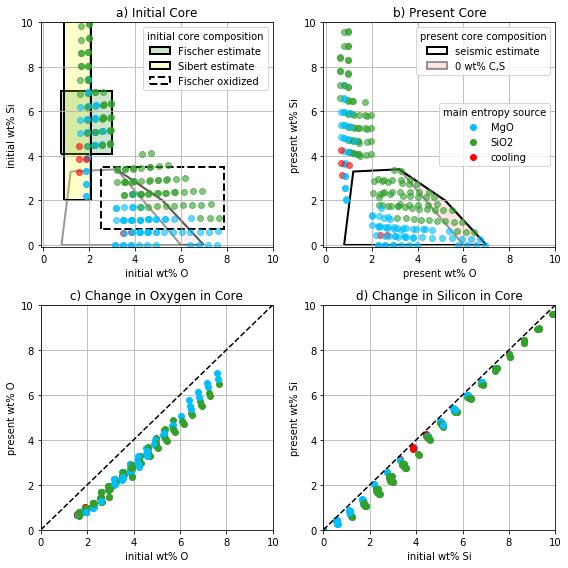

In [76]:
# Present-day constraints (Badro seismic model)
alpha = .6


df = df10
df = df[df['wt_O_p']<=10]
# df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]




ymax = 10
plt.figure(figsize=(8,8))
ax = plt.subplot(221)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
# cvar = 'maxE'
# cvals = df[cvar].fillna('FeO')
# cnames = ['FeO','MgO','SiO2','cooling']
# cvalsn = np.array([cnames.index(v)/3 for v in cvals])
# colors = plt.cm.rainbow(cvalsn)
# colors[df[cvar].isnull()] = (1,1,1,0)
colors = maxE_color(df)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,0,0,.05))
ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., ec=(0,0,0,1), fc=(0,.5,0,.2),label='Fischer estimate')
ax.add_patch(patch)
patch = patches.PathPatch(SiebertOSiPath, lw=2., ec=(0,0,0,1), fc=(1,1,0,.2),label='Sibert estimate')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0),label='Fischer oxidized')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)

plt.legend(title='initial core composition')

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% O')
plt.ylabel('initial wt% Si')
plt.title('a) Initial Core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()


ax = plt.subplot(222)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='seismic estimate')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,0,0,.1), label='0 wt% C,S')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='initial')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
# ax.add_patch(patch)
leg2 = plt.legend(loc='upper right', title='present core composition')

cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
leg1 = plt.legend(handles=lpatchs[1:], title='main entropy source', loc='center right')
plt.gca().add_artist(leg2)


for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('present wt% O')
plt.ylabel('present wt% Si')
plt.title('b) Present Core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()


plt.subplot(223)
xvar = 'wt_O_0'
yvar = 'wt_O_p'
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% O')
plt.ylabel('present wt% O')
plt.title('c) Change in Oxygen in Core')
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()


plt.subplot(224)
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% Si')
plt.ylabel('present wt% Si')
plt.title('d) Change in Silicon in Core')
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()

plt.tight_layout()
plt.savefig('Core_composition_initfinal_4panel_OxidizedAndPreferred_Fischer2015.pdf')

# Figure 3 Plot for Nature

In [30]:
import matplotlib as mpl
from matplotlib import gridspec
def remove_outliers(t,y,percent=0.3, N=3):
    Nends = N-1
    yo = y + np.mean(y)*.1
#     non_outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(Nends*y[Nends//2:-Nends//2])-1) < percent)[0]+Nends//2
    non_outliers = np.where( np.abs((yo[:-Nends]+yo[Nends:])/(2*yo[Nends//2:-Nends//2]) - 1) < percent)[0]+Nends//2
    return t[non_outliers], y[non_outliers]

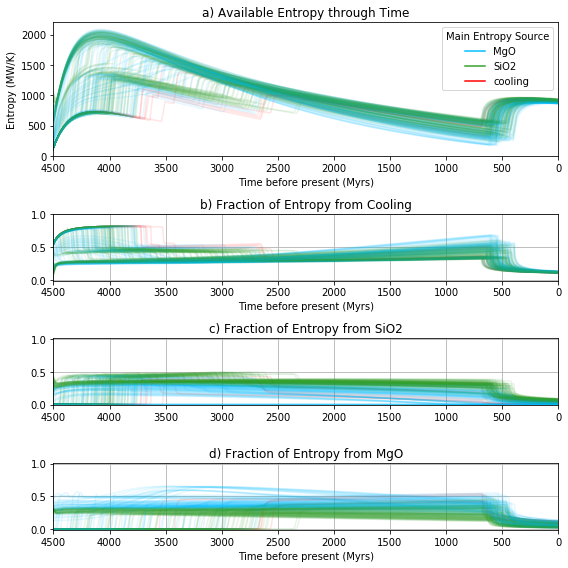

In [77]:
df = df10
df = df[df['wt_O_p']<=10]
# df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]

Cent = 1e6
Myrs = 365.25*3600*24*1e6
alpha = 0.1



plt.figure(figsize=(8,8))
# gs = gridspec.GridSpec(5, 1,height_ratios=(2,1,1,1,1)) 
gs = gridspec.GridSpec(4, 1,height_ratios=(2,1,1,1)) 

ax = plt.subplot(gs[0])
Navg = 3
colors = []
Esifrac = []
Emgfrac = []
Efefrac = []
Ecoolfrac = []
colors = []
tplts = []

for i,row in df.iterrows():
    foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
    if not os.path.exists(datadir+foldername+alldatafile):
        if not os.path.exists(datadir+foldername+solutionfile):
            continue
        pl, times, solution = dill.load(open(datadir+foldername+solutionfile,'rb'))
        tn, allp = pl.core_layer.compute_all_parameters(times, solution)
        dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
    else:
        tn, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
    allp.Eex = allp.Egm + allp.Egs + allp.Egf
    allp.Eic = allp.Eg + allp.El
#     cvals = row['maxE'].fillna('FeO')
    cnames = ['FeO','MgO','SiO2','cooling']
    color = get_color(row['maxE'])
#     cvalsn = np.array([cnames.index(v)/3 for v in cvals])
    tn = tn[-1]-tn
    tp,ep = remove_outliers(tn,allp.Ephi,N=5,percent=.02)
    Ct = 3.17e7*1e6
    plt.plot(tp/Ct,ep/1e6, '-',color=color, alpha=alpha)
    tplts.append(tn/Ct)
    Etot = allp.Ephi+allp.Ek
    Esifrac.append(allp.Egs/Etot)
    Emgfrac.append(allp.Egm/Etot)
    Efefrac.append(allp.Egf/Etot)
    Ecoolfrac.append(allp.Es/Etot)
    colors.append(color)

fline = mpl.lines.Line2D([],[],color=get_color('FeO'),label='FeO')
mline = mpl.lines.Line2D([],[],color=get_color('MgO'),label='MgO')
sline = mpl.lines.Line2D([],[],color=get_color('SiO2'),label='SiO2')
coolline = mpl.lines.Line2D([],[],color=get_color('cooling'),label='cooling')

plt.legend(loc='upper right',handles=[mline,sline,coolline], title='Main Entropy Source')
plt.ylim(0,2200)
plt.xlim(4500,0)
plt.xlabel('Time before present (Myrs)')
plt.ylabel('Entropy (MW/K)')
plt.title('a) Available Entropy through Time')
# plt.grid()

ax = plt.subplot(gs[1])
for t,e,c in zip(tplts,Ecoolfrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('b) Fraction of Entropy from Cooling')
plt.grid()
plt.xlabel('Time before present (Myrs)')

ax = plt.subplot(gs[2])
for t,e,c in zip(tplts,Esifrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('c) Fraction of Entropy from SiO2')
plt.grid()
# plt.xlabel('Time before present (Myrs)')

ax = plt.subplot(gs[3])
for t,e,c in zip(tplts,Emgfrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('d) Fraction of Entropy from MgO')
plt.grid()
plt.xlabel('Time before present (Myrs)')

# ax = plt.subplot(gs[4])
# for t,e,c in zip(tplts,Efefrac,colors):
# #     t,e = remove_outliers(t,e)
#     plt.plot(t,e,color=c,alpha=alpha)
# plt.ylim(-.01,1.01)
# plt.xlim(4500,0)
# plt.xlabel('Time before present (Myrs)')
# plt.title('Fraction of Entropy from FeO')
# plt.grid()

plt.tight_layout()
# plt.savefig('figure3_Fischer2015_SiOMgOcooling_withFeO.pdf')
plt.savefig('figure3_Fischer2015_SiOMgOcooling.pdf')

# Old Plots

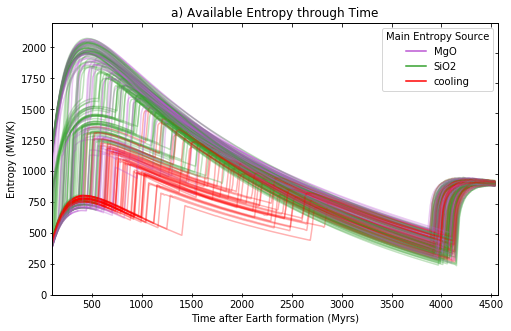

In [500]:
Cent = 1e6
Myrs = 365.25*3600*24*1e6
alpha = 0.3
plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(1, 1) 

ax = plt.subplot(gs[0])
Navg = 3
colors = []
Esifrac = []
Emgfrac = []
Efefrac = []
Ecoolfrac = []
for i,row in df.iterrows():
    foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
    if not os.path.exists(datadir+foldername+alldatafile):
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        tp, allp = pl.core_layer.compute_all_parameters(times, solution)
        dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
    else:
        tp, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
    allp.Eex = allp.Egm + allp.Egs + allp.Egf
    allp.Eic = allp.Eg + allp.El
#     cvals = row['maxE'].fillna('FeO')
    cnames = ['FeO','MgO','SiO2','cooling']
    color = get_color(row['maxE'])
#     cvalsn = np.array([cnames.index(v)/3 for v in cvals])
    tp,ep = remove_outliers(tp,allp.Ephi,N=5,percent=.02)
    Ct = 3.17e7*1e6
    plt.plot(tp/Ct,ep/1e6, '-',color=color, alpha=alpha)
    Esifrac.append(allp.Egs/allp.Ephi)
    Emgfrac.append(allp.Egs/allp.Ephi)
    Efefrac.append(allp.Egs/allp.Ephi)
    Ecoolfrac.append(allp.Egs/allp.Ephi)
    
fline = mpl.lines.Line2D([],[],color=get_color('FeO'),label='FeO')
mline = mpl.lines.Line2D([],[],color=get_color('MgO'),label='MgO')
sline = mpl.lines.Line2D([],[],color=get_color('SiO2'),label='SiO2')
coolline = mpl.lines.Line2D([],[],color=get_color('cooling'),label='cooling')

plt.legend(loc='upper right',handles=[mline,sline,coolline], title='Main Entropy Source')
plt.ylim(0,2200)
plt.xlim(100,4.568e3)
plt.xlabel('Time after Earth formation (Myrs)')
plt.ylabel('Entropy (MW/K)')
plt.title('a) Available Entropy through Time')
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

(0, 5)

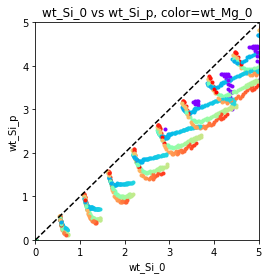

In [301]:
plt.subplot(223)
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_0'

cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)

plt.subplot(224)
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


In [457]:
tn[-1]

1.4392806681479037e+17

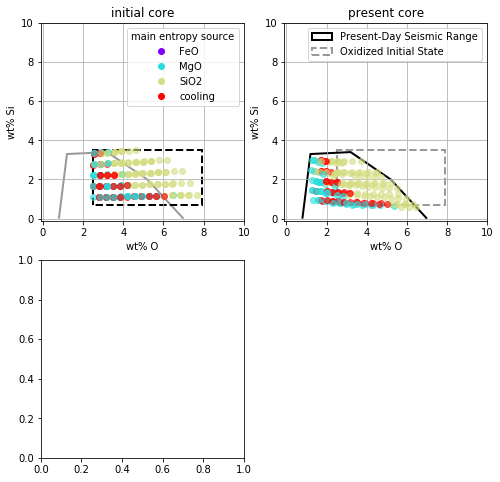

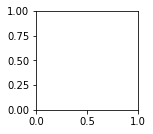

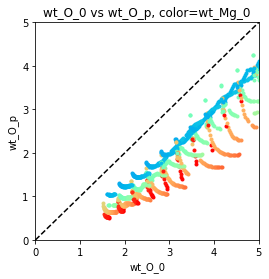

In [377]:
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()

plt.subplot(223)
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'

plt.figure(figsize=(4,4))
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)

plt.subplot(224)
xvar = 'wt_O_0'
yvar = 'wt_O_p'

plt.figure(figsize=(4,4))
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)
plt.savefig('Core_composition_initfinal_4panel_Oxidized_Fischer2015.pdf')

(0, 5)

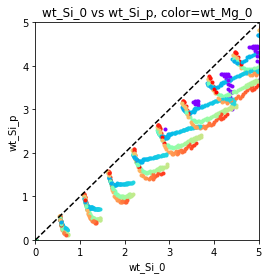

In [301]:
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_0'

cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


(0, 5)

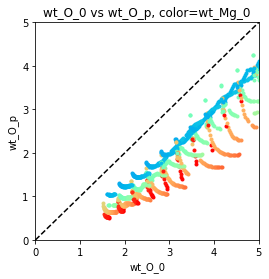

In [302]:
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


(0, 5)

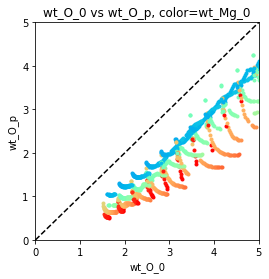

In [302]:
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


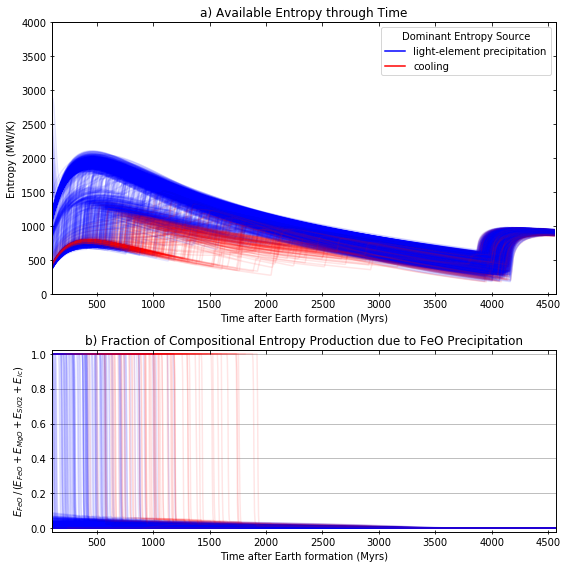

In [13]:
ax = plt.subplot(gs[1])
for i,(t_plt, params,_) in enumerate(all_ents):
    numer = params.Egf
    denom = (params.Eic+params.Eex)
    Ef_frac = np.divide(numer, denom, out=np.ones_like(numer)*np.nan, where=denom!=0.)
    plt.plot(t_plt/Myrs, Ef_frac, color=colors[i], alpha=alpha)
    
ep = 0.02
plt.ylim(0-ep,1+ep)
plt.xlim(100,4.568e3)
plt.xlabel('Time after Earth formation (Myrs)')
plt.ylabel(r'$E_{FeO} \,/\, (E_{FeO} + E_{MgO} + E_{SiO2} + E_{ic})$')
plt.title('b) Fraction of Compositional Entropy Production due to FeO Precipitation')
plt.grid(axis='y')
axt = ax.twiny()
# axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
# axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
# axr.set_yticklabels([])
# axr.set_ylim(ax.get_ylim())
# axr.set_yticks(ax.get_yticks())

plt.tight_layout()
plt.savefig('figure3_fixed_Fischer2015.pdf')